In [1]:
# visualising the result of applying filters
# to input
# i.e. visualising feature maps
# tutorial: https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/

In [247]:
## Standard imports
import numpy as np
import matplotlib.pyplot as plt
import skimage.io, scipy.ndimage, scipy.interpolate, scipy.signal, scipy.io.wavfile
import skimage.morphology, skimage.transform, skimage.feature, scipy.stats

%matplotlib inline
import matplotlib as mpl
#mpl.rcParams['figure.figsize'] = (18.0, 10.0)

#standard utilities
def show_image(img, title="untitled", cmap="gray", **kwargs):
    plt.figure()
    plt.imshow(img, cmap=cmap, interpolation="nearest", **kwargs)
    plt.axis("off")
    plt.title(title)
    
def apply_color(img, fn):
    return np.dstack((fn(img[:,:,0]),fn(img[:,:,1]),fn(img[:,:,2])))

def load_and_normalise(fname):
    return skimage.io.imread(fname) / 256.0

def load_gray(f):
    return skimage.color.rgb2gray(load_and_normalise(f))

def reshape(img, e=False):
    if e:
        return np.reshape(img,(encoder.output.shape[1], encoder.output.shape[2]*encoder.output.shape[3]))
    return np.reshape(img, (image_width, image_height))

def plot_results(input_imgs, output_imgs):
    fig = plt.figure(figsize=(15, 15))
    for i in range(1, 6):
        ax = fig.add_subplot(1, 5, i)
        plt.imshow(reshape(input_imgs[i+10]), cmap='gist_yarg')
        ax.axis('off')

    for i in range(1, 6):
        ax = fig.add_subplot(2, 5, i)
        plt.imshow(reshape(output_imgs[i+10]), cmap='gist_yarg')
        ax.axis('off') 

In [276]:
# resize images
# read images into arrays
# read resized images back into folder for future use

import matplotlib.pyplot as plt
%matplotlib inline

import os
import numpy as np
from skimage.io import imread
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.util import crop
from PIL import Image

folder = '/Users/Leonore/Documents/Workspace/l4proj/data/raw'

filenames = [os.path.join(folder, f)for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
filenames = sorted(filenames)

image_width = 200
image_height = 200

dataset = np.ndarray(shape=(len(filenames), image_width, image_height), dtype=np.float32)

i = 0
for file in filenames:
    try:
        image = load_and_normalise(file)
        to_crop = (image.shape[0]-image_width)/2
        image_resized = crop(image, (to_crop, to_crop))
        dataset[i] = image_resized
    except Exception as e:
        print(e)
        print("{} is causing issues".format(file))
    i += 1

Could not find a format to read the specified file in mode 'i'
/Users/Leonore/Documents/Workspace/l4proj/data/raw/.DS_Store is causing issues


In [277]:
filenames[0:10]

['/Users/Leonore/Documents/Workspace/l4proj/data/raw/.DS_Store',
 '/Users/Leonore/Documents/Workspace/l4proj/data/raw/A - 10(fld 1 wv FITC - FITC).tif',
 '/Users/Leonore/Documents/Workspace/l4proj/data/raw/A - 10(fld 1 wv TexasRed - TexasRed).tif',
 '/Users/Leonore/Documents/Workspace/l4proj/data/raw/A - 11(fld 1 wv FITC - FITC).tif',
 '/Users/Leonore/Documents/Workspace/l4proj/data/raw/A - 11(fld 1 wv TexasRed - TexasRed).tif',
 '/Users/Leonore/Documents/Workspace/l4proj/data/raw/A - 13(fld 1 wv FITC - FITC).tif',
 '/Users/Leonore/Documents/Workspace/l4proj/data/raw/A - 13(fld 1 wv TexasRed - TexasRed).tif',
 '/Users/Leonore/Documents/Workspace/l4proj/data/raw/A - 14(fld 1 wv FITC - FITC).tif',
 '/Users/Leonore/Documents/Workspace/l4proj/data/raw/A - 14(fld 1 wv TexasRed - TexasRed).tif',
 '/Users/Leonore/Documents/Workspace/l4proj/data/raw/A - 15(fld 1 wv FITC - FITC).tif']

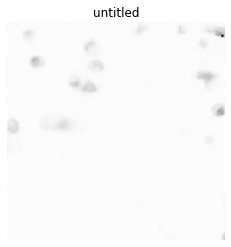

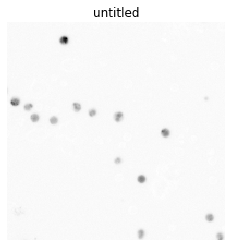

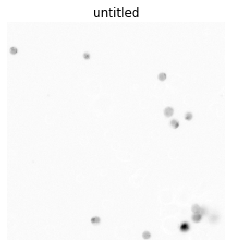

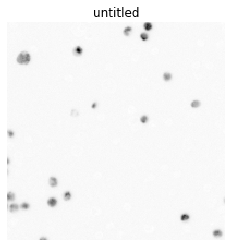

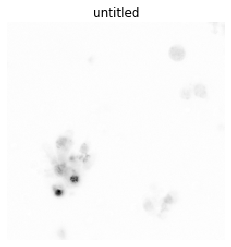

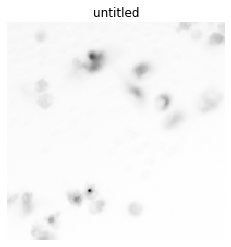

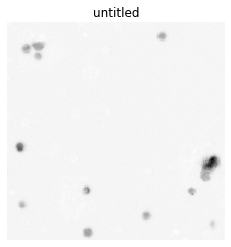

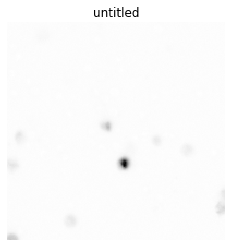

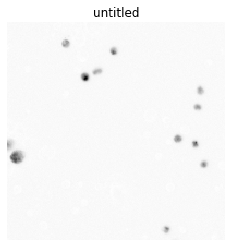

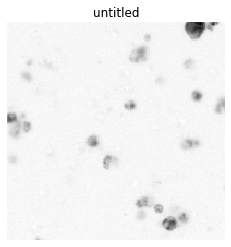

In [269]:
for i in range(22, 32):
    show_image(dataset[i], cmap='gist_yarg')

(1048, 1048)


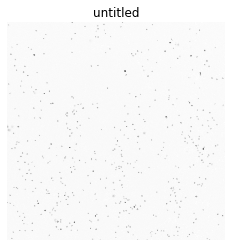

In [267]:
img = load_and_normalise(filenames[0])
img = crop(img, (500))
print(img.shape)
show_image(img, cmap="gist_yarg")

In [278]:
from sklearn.model_selection import train_test_split

# splitting and discarding labels as we don't need them
x_train, x_test, _, _ = train_test_split(dataset, dataset, test_size=0.2, random_state=11)

x_train = np.reshape(x_train, (len(x_train), image_width, image_height, 1))
x_test = np.reshape(x_test, (len(x_test), image_width, image_height, 1))

x_train.shape

(471, 200, 200, 1)

In [279]:
# build autoencoder for dataset

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(image_width, image_height, 1))  # adapt this if using `channels_first` image data format

x =  Conv2D(64, (5, 5), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x =  Conv2D(64, (5, 5), activation='relu', padding='same')(x)
# this will help going back the original image dimensions
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(1, (3, 3), padding='same')(x)

In [280]:
model= Model(input_img, decoded)

In [281]:
model.summary()

Model: "model_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_41 (InputLayer)        (None, 200, 200, 1)       0         
_________________________________________________________________
conv2d_325 (Conv2D)          (None, 200, 200, 64)      1664      
_________________________________________________________________
max_pooling2d_104 (MaxPoolin (None, 100, 100, 64)      0         
_________________________________________________________________
conv2d_326 (Conv2D)          (None, 100, 100, 32)      18464     
_________________________________________________________________
conv2d_327 (Conv2D)          (None, 100, 100, 16)      4624      
_________________________________________________________________
max_pooling2d_105 (MaxPoolin (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_328 (Conv2D)          (None, 50, 50, 16)        232

In [282]:
#encoded_imgs = encoder.predict(x_test)
decoded_imgs = model.predict(x_test)

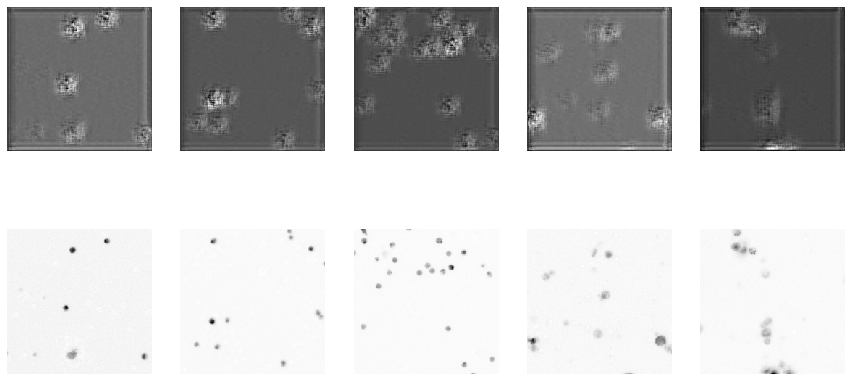

In [283]:
plot_results(x_test, decoded_imgs)

In [ ]:
idx = 23
sample = np.expand_dims(x_test[idx], axis=0)
d1 = np.reshape(decoded_imgs[idx], (image_width, image_height))
before = np.reshape(sample, (image_width, image_height))
compressed = np.reshape(encoded_imgs[idx],(encoder.output.shape[1], encoder.output.shape[2]*encoder.output.shape[3]))
show_image(before, 'original', cmap='gist_yarg')
show_image(compressed, "compressed representation", cmap="gist_yarg")
show_image(d1, 'decoded', cmap='gist_yarg')

In [73]:
compressed.shape

(25, 1600)

In [ ]:
sample.shape

In [ ]:
encoded_imgs[idx].shape

In [ ]:
d1 = np.reshape(decoded_imgs[0], (image_width, image_height))
before = np.reshape(sample, (image_width, image_height))filters, biases = model.layers[1].get_weights()

In [ ]:
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

In [ ]:
n_filters, ix = 6, 1
for i in range(n_filters):
    f = filters[:,:,:,i]
    #plt.figure()
    #plt.imshow(f[:,:,0], cmap='gray')
    ix+=1

In [ ]:
for i in range(len(model.layers)):
    layer = model.layers[i]
    if 'conv' not in layer.name:
        continue
    print(i, layer.name, layer.output.shape)

In [ ]:
# redefine model to output right after the first hidden layer
feature_model = Model(inputs=model.inputs, outputs=model.layers[1].output)

In [ ]:
x_train[12].shape

In [ ]:
sample = np.expand_dims(x_train[44], axis=0)

In [ ]:
sample.shape

In [ ]:
feature_maps = feature_model.predict(sample)

In [ ]:
feature_maps.shape

In [ ]:
square = 4
ix = 1
for _ in range(square):
    for _ in range(square):
        plt.figure()
        plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1

In [ ]:
# plot the feature maps for each layer 
encoding_idx = [1, 3, 5]
outputs = [model.layers[i].output for i in encoding_idx]
feature_model = Model(inputs=model.inputs, output=outputs)
feature_maps = feature_model.predict(sample)
square = 4
for fmap in feature_maps:
    ix = 1
    for _ in range(square):
        for _ in range(square):
            plt.figure()
            plt.imshow(fmap[0, :, :, ix-1], cmap='gray')
        ix += 1
    plt.show()

In [ ]:
# plot the decompressed images from each layer
decoding_idx = [7, 9, 11]
outputs = [model.layers[i].output for i in decoding_idx]
decode_model = Model(inputs=model.inputs, outputs=outputs)
output_maps = decode_model.predict(sample)
square = 8
for out in output_maps:
    ix = 1
    for _ in range(square):
        plt.figure()
        plt.imshow(out[0, :, :, ix-1], cmap='gray')
        ix+=1